In [1]:
import numpy as np
import multiprocessing as mp
from multiprocessing import shared_memory
import shared_array as sa
import gc

In [2]:
def get_np(s, iterations):
    def foo(send_q,return_q):
        import shared_array as sa
        import gc
        s = 0.0
        while True:
            #gc.collect()
            call_arr = send_q.get()
            if call_arr[0] =='array':
                arr = call_arr[1]
                s += np.sum(arr[:])
            else:
                return_q.put(s)
                break


    send_q = mp.Queue(3)
    return_q = mp.Queue()
    p = mp.Process(target=foo, args=(send_q,return_q))
    p.start()
    import time
    t0 = time.time()
    for i in range(iterations):
        if i % 1000 == 0:
            gc.collect()
        myarr = np.empty([s], float)
        myarr[:] = 1
        send_q.put(('array',myarr))
    send_q.put(('done'))


    p.join()
    t1 = time.time()
    print(f'np {s} time = {t1-t0:.3f} np array over queue', end = '\r')
    return t1-t0

In [3]:
import multiprocessing as mp
import shared_array as sa

def get_sa(s, iterations):
    def foo(send_q,return_q):
        import shared_array as sa
        s = 0.0
        while True:
            call_handle = send_q.get()
            if call_handle[0] =='array':
                handle = call_handle[1]
                arr = sa.sharedArray(handle)
                s += np.sum(arr[:])
                arr.close()
                arr.unlink()
            else:
                return_q.put(s)
                break


    send_q = mp.Queue(3)
    return_q = mp.Queue()
    p = mp.Process(target=foo, args=(send_q,return_q))
    p.start()
    import time
    t0 = time.time()
    for i in range(iterations):
        myarr = sa.sharedArray([s], float)
        myarr[:] = 1
        send_q.put(('array',myarr.handle))
        myarr.close()
    send_q.put(('done'))

    p.join()
    t1 = time.time()
    print(f'sa {s} time = {t1-t0:.3f} new shared array handle over queue', end = '\r')
    return t1-t0


In [4]:
ss = np.arange(201)*10000+1
iterations = 300
nps = [get_np(s,iterations) for s in ss]

In [5]:
sas = [get_sa(s,iterations) for s in ss]

/tmp/ipykernel_8777/1835918464.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim([0,ss[-1]/10**3])


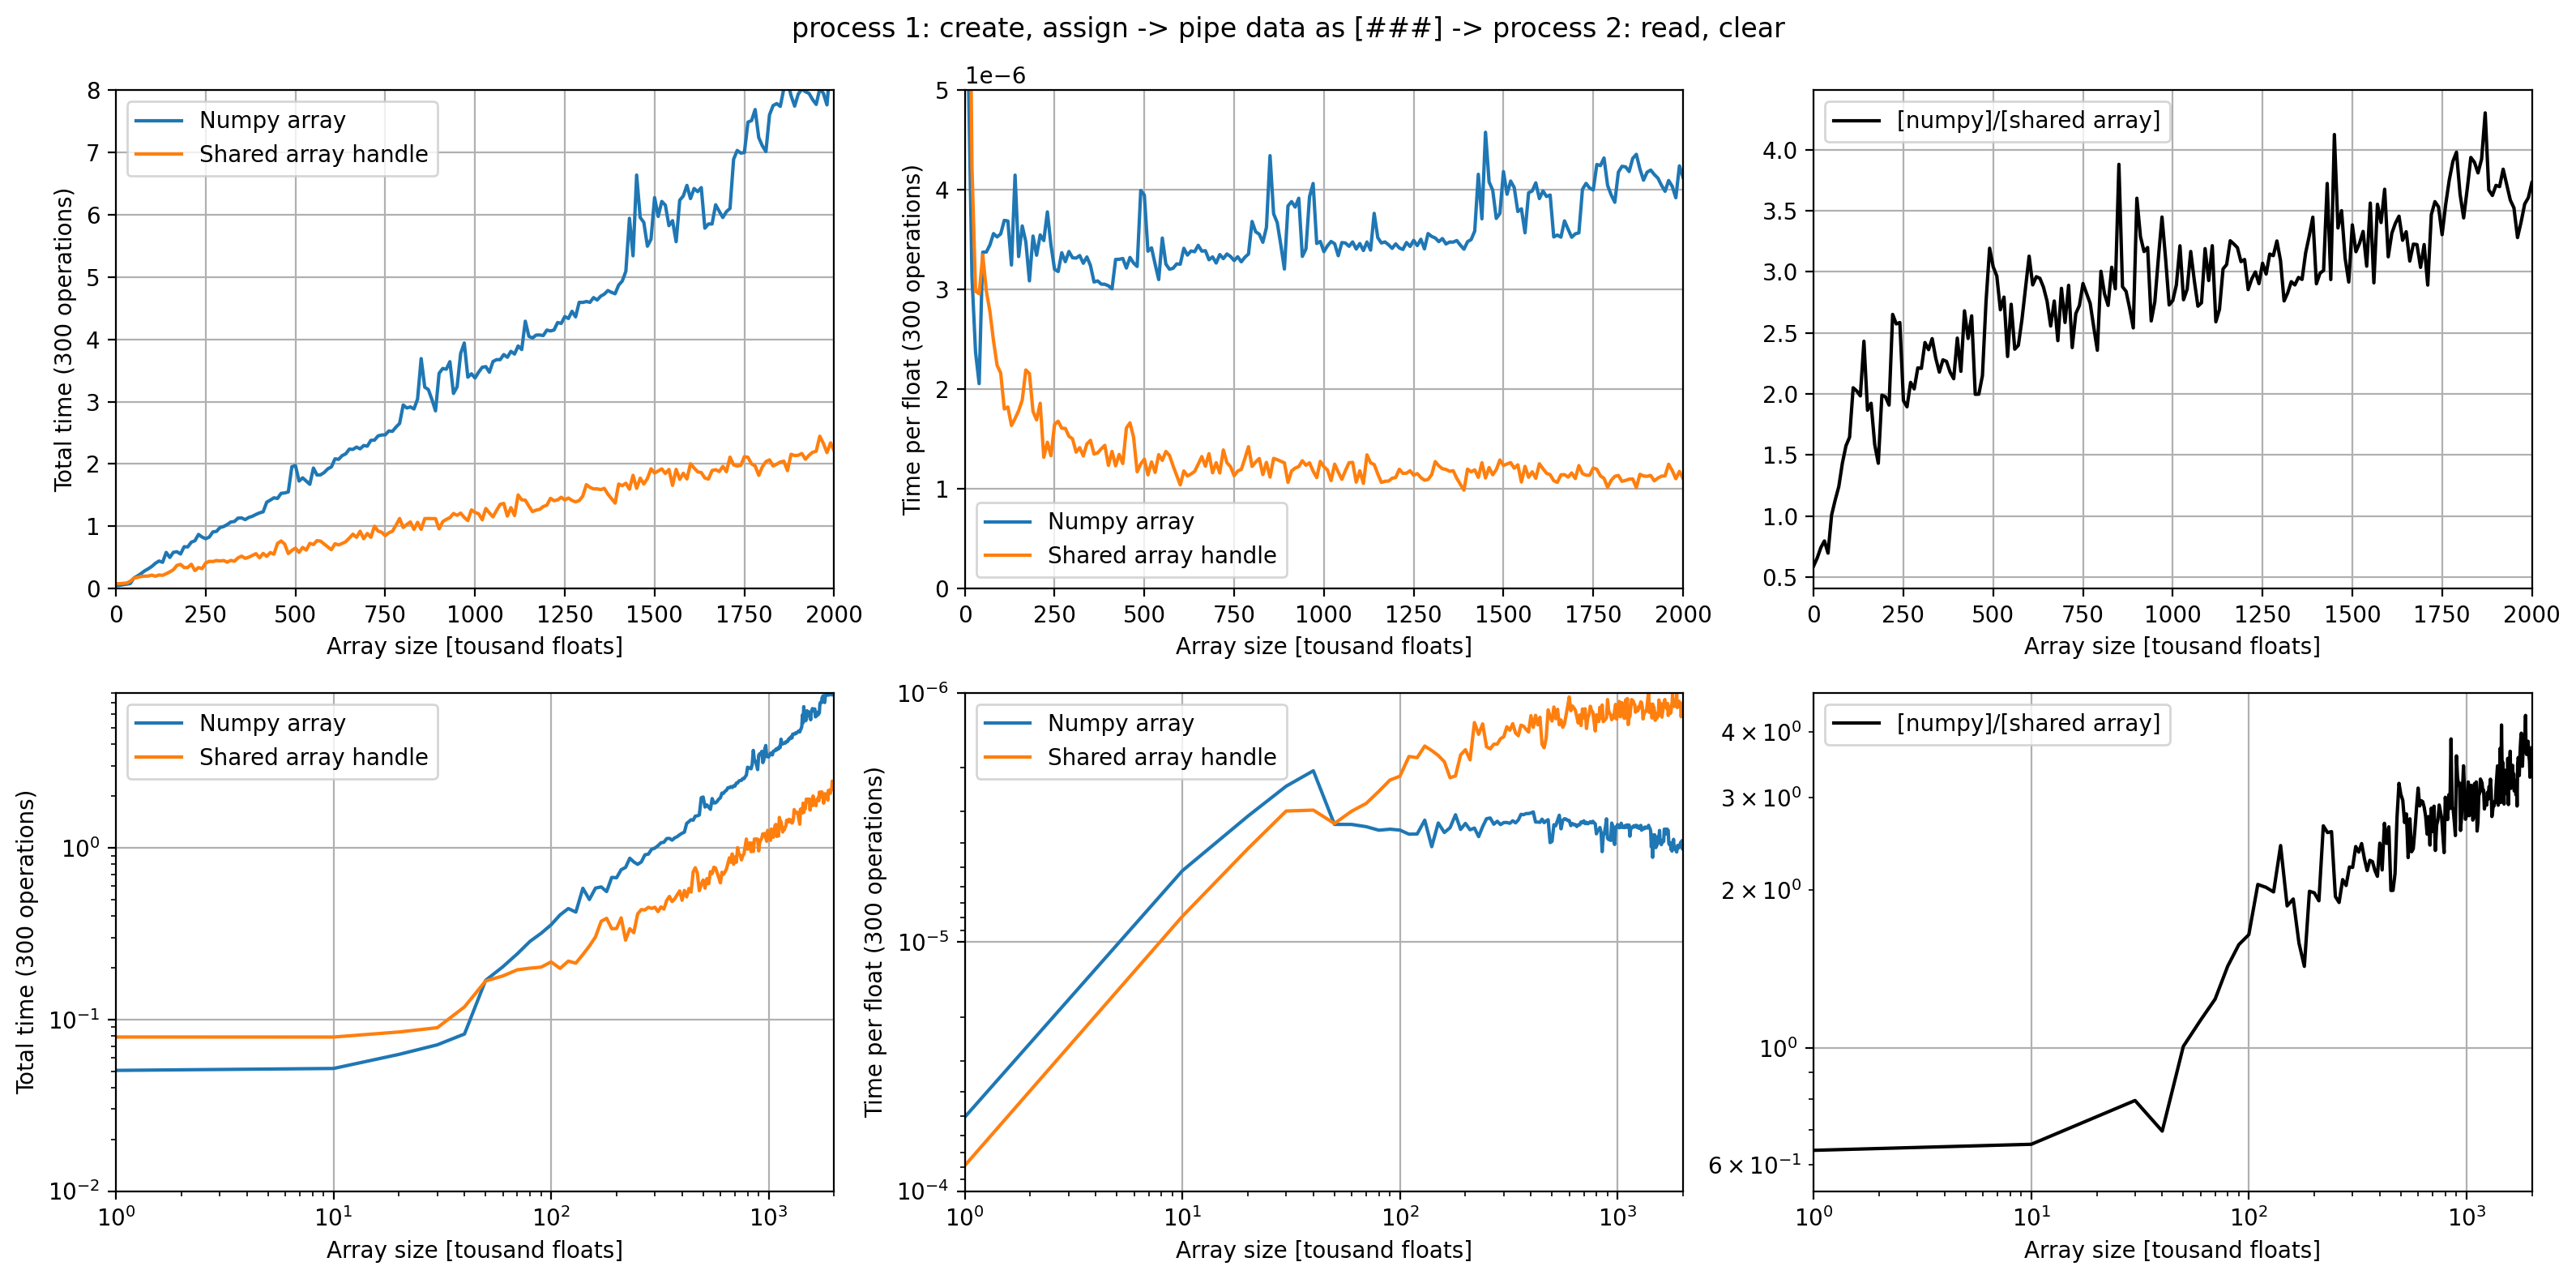

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3, figsize = (16,8), dpi = 200)
axes = axes.ravel()

nps = np.array(nps)
sas = np.array(sas)
axes[0].plot(ss/10**3,nps, label = 'Numpy array')
axes[0].plot(ss/10**3,sas, label = 'Shared array handle')
axes[0].set_ylim([0,8])
axes[3].loglog(ss/10**3,nps, label = 'Numpy array')
axes[3].loglog(ss/10**3,sas, label = 'Shared array handle')
axes[3].set_ylim([0.01,8])
axes[3].set_xlim([1,2000])

axes[1].plot(ss/10**3,nps/(ss), label = 'Numpy array')
axes[1].plot(ss/10**3,sas/(ss), label = 'Shared array handle')
axes[1].set_ylim([0, 0.5*10**-5])
axes[4].loglog(ss/10**3,nps/(ss), label = 'Numpy array')
axes[4].loglog(ss/10**3,sas/(ss), label = 'Shared array handle')
axes[4].set_ylim([10**-4,10**-6])
axes[4].set_xlim([1,2000])


axes[2].plot(ss/10**3,nps/sas, label = '[numpy]/[shared array]', color = [0,0,0])
axes[5].loglog(ss/10**3,nps/sas, label = '[numpy]/[shared array]', color = [0,0,0])
axes[5].set_xlim([1,2000])


axes[0].set_ylabel(f'Total time ({iterations} operations)')
axes[3].set_ylabel(f'Total time ({iterations} operations)')
axes[1].set_ylabel(f'Time per float ({iterations} operations)')
axes[4].set_ylabel(f'Time per float ({iterations} operations)')
for ax in axes:
    ax.set_xlabel('Array size [tousand floats]')
    ax.set_xlim([0,ss[-1]/10**3])
    ax.legend()
    ax.grid()
fig.suptitle('process 1: create, assign -> pipe data as [###] -> process 2: read, clear')
fig.tight_layout()